# 1. VERİ YÜKLEME VE ÖN HAZIRLIK

## 1.1. Kütüphanelerin İçe Aktarılması
Bu bölümde, proje boyunca veri manipülasyonu (`pandas`, `numpy`), görüntü işleme (`cv2`, `PIL`), veri görselleştirme (`matplotlib`, `seaborn`) ve dosya sistemi işlemleri (`os`, `glob`) için gerekli olan temel Python kütüphaneleri çalışma ortamına dahil edilmektedir.

In [1]:
# Gerekli kütüphaneleri yüklüyoruz (Colab'de genelde vardır ama garanti olsun)
!pip install opendatasets pandas numpy matplotlib seaborn opencv-python

import os
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import opendatasets as od # Kaggle'dan veri çekmek için pratik bir kütüphane

# Çıktıların hücre içinde görünmesi için
%matplotlib inline

print("Kütüphaneler başarıyla yüklendi ve import edildi.")

Kütüphaneler başarıyla yüklendi ve import edildi.


## Veri Setinin Kaynaktan Çekilmesi
Projede kullanılacak olan **ISIC 2018 Skin Lesion Dataset** (veya eşdeğer Kaggle sürümü), `opendatasets` kütüphanesi aracılığıyla doğrudan Kaggle sunucularından Colab ortamına indirilmektedir. Bu işlem, verinin manuel yüklenmesine gerek kalmadan otomatik olarak çalışma dizinine alınmasını sağlar.

In [2]:
# Kaggle veri seti URL'si
dataset_url = 'https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic'

# Veriyi indir (Sizden Kaggle username ve key isteyebilir, ya da manuel yüklediyseniz burayı yorum satırı yapın)
# Eğer manuel yüklediyseniz dataset_dir = "/content/Skin cancer ISIC The International Skin Imaging Collaboration" yapın.
try:
    od.download(dataset_url)
    dataset_dir = './skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration'
except:
    print("Veri seti indirilemedi veya zaten mevcut. Lütfen dosya yolunu kontrol edin.")
    # Varsayılan yol (Colab'e manuel yükleme yapılırsa genelde burasıdır)
    dataset_dir = '/content/Skin cancer ISIC The International Skin Imaging Collaboration'

print(f"Veri seti dizini: {dataset_dir}")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: KGAT_e25ee670540274b3d9095001af0645ac
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic


100%|██████████| 786M/786M [00:04<00:00, 204MB/s] 



Veri seti dizini: ./skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration


## 1.2. Veri Setinin Yüklenmesi (DataFrame Oluşturma)
İndirilen veri seti klasör yapısı taranarak (recursive search), her bir görüntü dosyasının **dosya yolu (file path)** ve bulunduğu klasör isminden türetilen **etiket (label)** bilgisi alınır. Bu veriler, analiz ve işlem kolaylığı sağlaması amacıyla yapısal bir **Pandas DataFrame** (`train_df`) içerisine aktarılır.

In [3]:
# Veri yollarını ve etiketleri tutacak listeler
file_paths = []
labels = []

# os.walk ile tüm alt klasörleri geziyoruz
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Tam dosya yolu
            full_path = os.path.join(root, file)
            file_paths.append(full_path)

            # Klasör ismi etiketimiz (label) olacak
            label = os.path.basename(root)
            labels.append(label)

# DataFrame oluşturma
train_df = pd.DataFrame({
    'file_path': file_paths,
    'label': labels
})

# İlk birkaç satırı görüntüle
print("DataFrame İlk 5 Satır:")
display(train_df.head())

# Toplam görüntü sayısını ekrana yazdır
print(f"\nToplam Görüntü Sayısı: {len(train_df)}")

# Sınıf dağılımını görmek için (Ekstra profesyonellik)
print("\nSınıf Dağılımı:")
print(train_df['label'].value_counts())

DataFrame İlk 5 Satır:


,file_path,label
0,./skin-cancer9-classesisic/Skin cancer ISIC Th...,basal cell carcinoma
1,./skin-cancer9-classesisic/Skin cancer ISIC Th...,basal cell carcinoma
2,./skin-cancer9-classesisic/Skin cancer ISIC Th...,basal cell carcinoma
3,./skin-cancer9-classesisic/Skin cancer ISIC Th...,basal cell carcinoma
4,./skin-cancer9-classesisic/Skin cancer ISIC Th...,basal cell carcinoma



Toplam Görüntü Sayısı: 2357

Sınıf Dağılımı:
label
pigmented benign keratosis    478
melanoma                      454
basal cell carcinoma          392
nevus                         373
squamous cell carcinoma       197
vascular lesion               142
actinic keratosis             130
dermatofibroma                111
seborrheic keratosis           80
Name: count, dtype: int64


## 1.3. Veri Özelliklerinin İncelenmesi
Veri setindeki görüntülerin teknik özelliklerini doğrulamak amacıyla bir analiz gerçekleştirilir. Bu adımda:
* **Çözünürlük Analizi:** Görüntülerin genişlik ve yükseklik dağılımları incelenir.
* **Kanal Kontrolü:** Görüntülerin renkli (RGB - 3 kanal) mi yoksa gri tonlamalı (Grayscale - 1 kanal) mı olduğu doğrulanır.
* **Dosya Boyutu:** Görüntülerin diskteki boyut dağılımları analiz edilir.

Görüntü özellikleri analiz ediliyor, lütfen bekleyin...

Tespit Edilen Kanal Sayıları: [3]
-> Veri seti RGB (Renkli) görüntüler içeriyor.


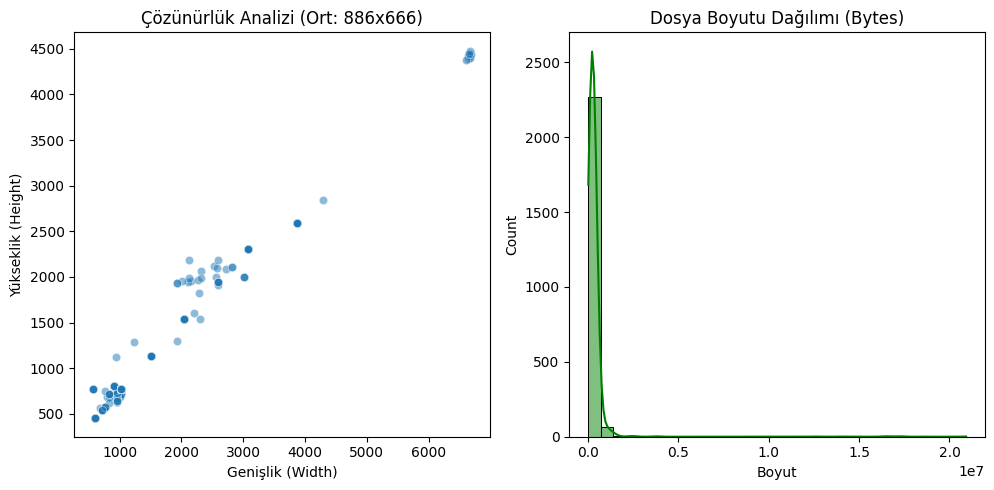


İstatistiksel Özet:


,Width,Height,File_Size
count,2357.000000,2357.000000,2.357000e+03
mean,886.455240,666.516334,3.504364e+05
std,683.775442,491.239740,1.082073e+06
min,576.000000,450.000000,2.472700e+04
25%,600.000000,450.000000,2.083570e+05
50%,600.000000,450.000000,2.607190e+05
75%,1024.000000,768.000000,3.056800e+05
max,6688.000000,4479.000000,2.092037e+07


In [4]:
def analyze_images(df):
    widths = []
    heights = []
    channels = []
    file_sizes = [] # Byte cinsinden

    print("Görüntü özellikleri analiz ediliyor, lütfen bekleyin...")

    for path in df['file_path']:
        # Dosya boyutu
        size = os.path.getsize(path)
        file_sizes.append(size)

        # Görüntü özellikleri (cv2 ile sadece header okumaya çalışmak hızlıdır ama imread garantidir)
        img = cv2.imread(path)
        if img is not None:
            h, w, c = img.shape
            heights.append(h)
            widths.append(w)
            channels.append(c)

    return widths, heights, channels, file_sizes

# Analizi çalıştır
widths, heights, channels, file_sizes = analyze_images(train_df)

# Sonuçları Görselleştirme ve Yorumlama
plt.figure(figsize=(15, 5))

# 1. Çözünürlük Analizi
plt.subplot(1, 3, 1)
sns.scatterplot(x=widths, y=heights, alpha=0.5)
plt.title(f"Çözünürlük Analizi (Ort: {int(np.mean(widths))}x{int(np.mean(heights))})")
plt.xlabel("Genişlik (Width)")
plt.ylabel("Yükseklik (Height)")

# 2. Kanal Sayısı Kontrolü
unique_channels = np.unique(channels)
print(f"\nTespit Edilen Kanal Sayıları: {unique_channels}")
if 3 in unique_channels:
    print("-> Veri seti RGB (Renkli) görüntüler içeriyor.")
else:
    print("-> Veri seti Grayscale olabilir.")

# 3. Dosya Boyutu Dağılımı
plt.subplot(1, 3, 2)
sns.histplot(file_sizes, bins=30, kde=True, color='green')
plt.title("Dosya Boyutu Dağılımı (Bytes)")
plt.xlabel("Boyut")

plt.tight_layout()
plt.show()

# İstatistiksel özet
df_stats = pd.DataFrame({'Width': widths, 'Height': heights, 'File_Size': file_sizes})
print("\nİstatistiksel Özet:")
display(df_stats.describe())

# 2. GÖRÜNTÜ İŞLEME VE GÖRSELLEŞTİRME

## 2.1. Rastgele Görüntü Seçimi ve Dönüşümü
Veri setinden rastgele 9 adet örnek görüntü seçilir. Her bir görüntü için:
1.  Orijinal **RGB** (Renkli) hali,
2.  OpenCV kullanılarak dönüştürülmüş **Grayscale** (Gri Tonlamalı) hali,
yan yana olacak şekilde görselleştirilir. Bu adım, renk bilgisinin kaybolduğunda yapısal detayların (kenarlar, lezyon sınırları) nasıl göründüğünü anlamak için kritiktir.

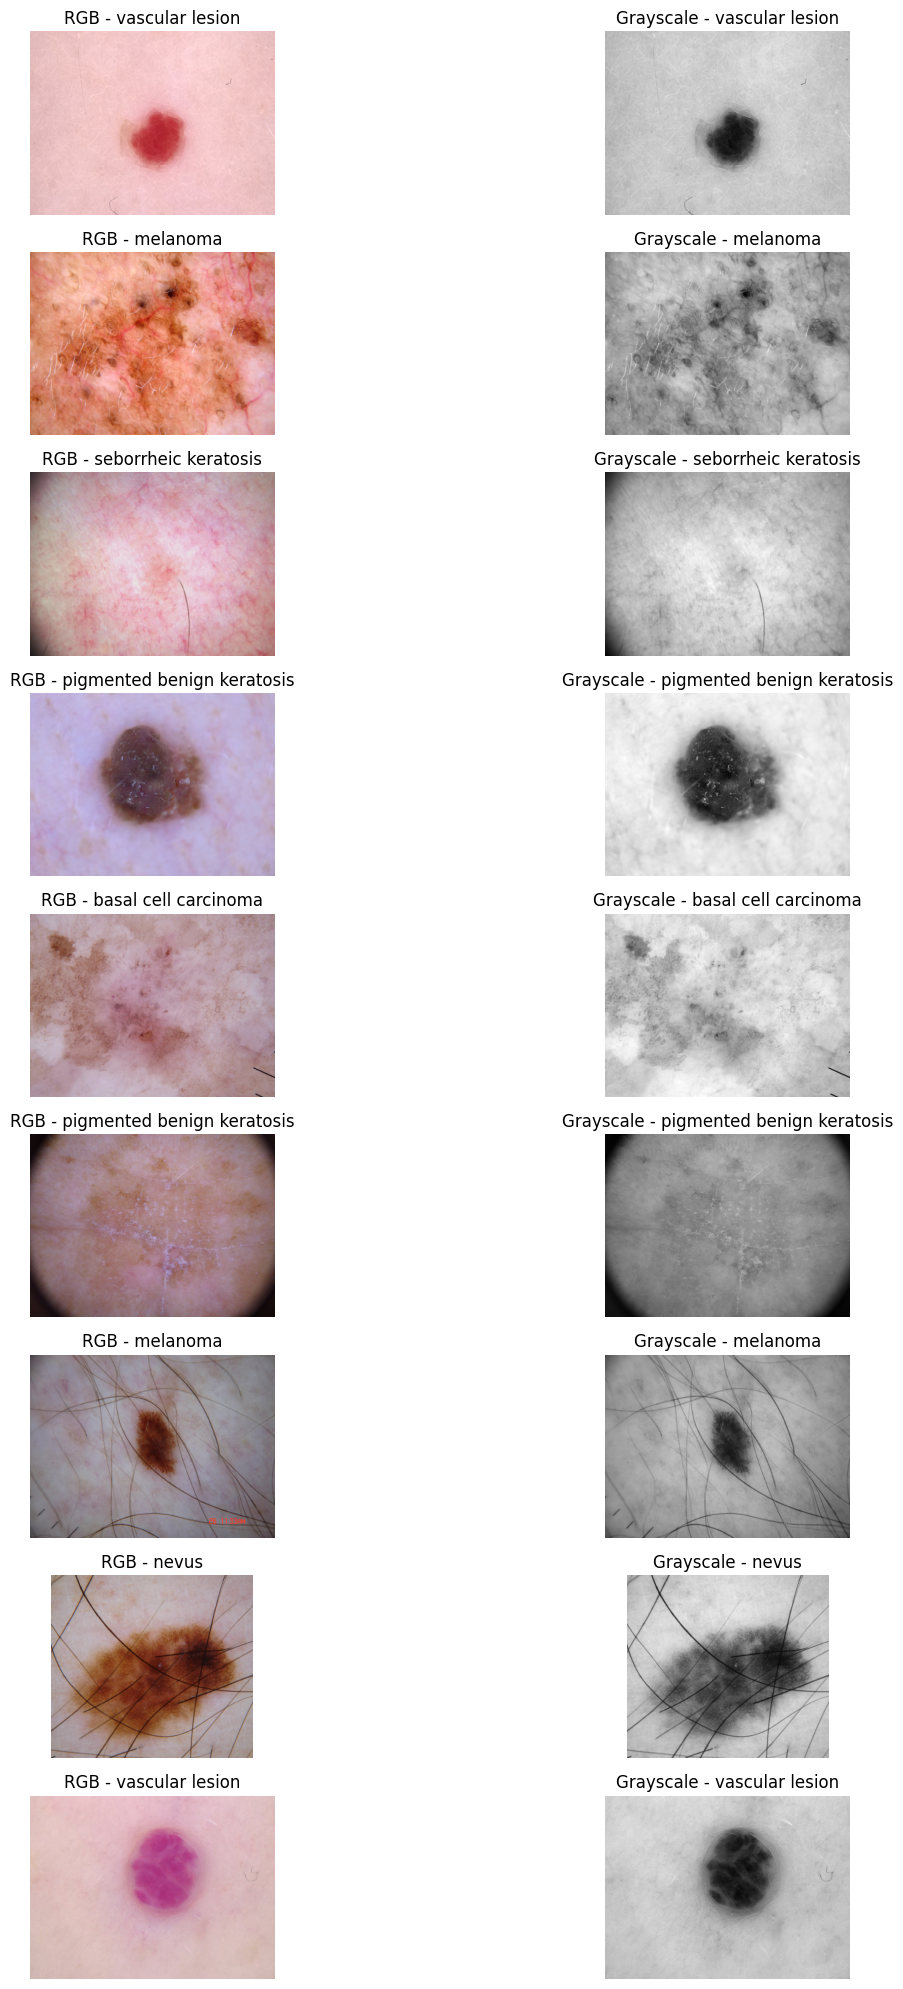

In [5]:
# Rastgele 9 örnek seç
random_samples = train_df.sample(n=9, random_state=42) # random_state sabit sonuç için

plt.figure(figsize=(15, 20))
idx = 0

# İstatistikleri saklamak için bir liste (Bir sonraki adım için hazırlık)
selected_images_stats = []

for _, row in random_samples.iterrows():
    path = row['file_path']
    label = row['label']

    # Görüntüyü oku (OpenCV BGR okur, RGB'ye çevirmeliyiz)
    img_bgr = cv2.imread(path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Grayscale hali
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # Verileri sonraki analiz için sakla
    selected_images_stats.append({
        'label': label,
        'rgb': img_rgb,
        'gray': img_gray,
        'path': path
    })

    # Çizim (RGB)
    idx += 1
    plt.subplot(9, 2, idx)
    plt.imshow(img_rgb)
    plt.title(f"RGB - {label}")
    plt.axis('off')

    # Çizim (Grayscale)
    idx += 1
    plt.subplot(9, 2, idx)
    plt.imshow(img_gray, cmap='gray')
    plt.title(f"Grayscale - {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 2.2. Görüntülerin İstatistiksel Özellikleri
Seçilen örnek görüntülerin piksel yoğunluk değerleri üzerinden temel istatistiksel analizler yapılır. Hem RGB hem de Grayscale formatları için:
* **Minimum ve Maksimum Piksel Değerleri:** Parlaklık aralığını gösterir.
* **Ortalama (Mean):** Genel parlaklık seviyesini ifade eder.
* **Standart Sapma (Std):** Görüntüdeki kontrastı ve bilgi çeşitliliğini temsil eder.
Sonuçlar karşılaştırmalı bir tablo olarak sunulmaktadır.

In [6]:
stats_data = []

for item in selected_images_stats:
    label = item['label']
    img_rgb = item['rgb']
    img_gray = item['gray']

    # RGB İstatistikleri (Tüm kanalların ortalaması alınır veya flatten edilir)
    rgb_min = np.min(img_rgb)
    rgb_max = np.max(img_rgb)
    rgb_mean = np.mean(img_rgb)
    rgb_std = np.std(img_rgb)

    # Grayscale İstatistikleri
    gray_min = np.min(img_gray)
    gray_max = np.max(img_gray)
    gray_mean = np.mean(img_gray)
    gray_std = np.std(img_gray)

    stats_data.append({
        'Sınıf': label,
        'Tip': 'RGB',
        'Min': rgb_min, 'Max': rgb_max, 'Ortalama': f"{rgb_mean:.2f}", 'Std Sapma': f"{rgb_std:.2f}"
    })

    stats_data.append({
        'Sınıf': label,
        'Tip': 'Grayscale',
        'Min': gray_min, 'Max': gray_max, 'Ortalama': f"{gray_mean:.2f}", 'Std Sapma': f"{gray_std:.2f}"
    })

# Tablo haline getirip gösterelim
df_stats_comparison = pd.DataFrame(stats_data)
print("Seçilen Görüntülerin İstatistiksel Karşılaştırması:")
display(df_stats_comparison)

# Yorum
print("\nYorum: Genellikle RGB görüntülerin standart sapması, renk varyasyonundan dolayı grayscale'e göre farklılık gösterebilir. Grayscale işleminde veri tek kanala indirgendiği için ortalama değerler parlaklık yoğunluğunu temsil eder.")

Seçilen Görüntülerin İstatistiksel Karşılaştırması:


,Sınıf,Tip,Min,Max,Ortalama,Std Sapma
0,vascular lesion,RGB,25,255,206.42,32.81
1,vascular lesion,Grayscale,67,249,204.42,23.29
2,melanoma,RGB,0,255,159.79,53.12
3,melanoma,Grayscale,9,255,161.82,26.07
4,seborrheic keratosis,RGB,21,250,181.87,31.77
5,seborrheic keratosis,Grayscale,23,235,179.01,24.84
6,pigmented benign keratosis,RGB,21,243,171.28,42.77
7,pigmented benign keratosis,Grayscale,38,199,163.71,37.50
8,basal cell carcinoma,RGB,0,208,159.36,24.36
9,basal cell carcinoma,Grayscale,8,197,156.81,18.14



Yorum: Genellikle RGB görüntülerin standart sapması, renk varyasyonundan dolayı grayscale'e göre farklılık gösterebilir. Grayscale işleminde veri tek kanala indirgendiği için ortalama değerler parlaklık yoğunluğunu temsil eder.


## 2.3. Histogram Analizi (RGB + Grayscale)
Görüntü işlemede parlaklık dağılımını ve renk yoğunluğunu analiz etmenin en etkili yolu histogramlardır. Bu bölümde seçilen her görüntü için:
* **RGB Histogramı:** Kırmızı, Yeşil ve Mavi kanalların piksel yoğunluk dağılımları ayrı ayrı çizilir.
* **Grayscale Histogramı:** Tek kanallı gri tonlama yoğunluk dağılımı analiz edilir.
Bu grafikler, lezyonların ışıklandırma koşullarını ve renk baskınlıklarını yorumlamamızı sağlar.

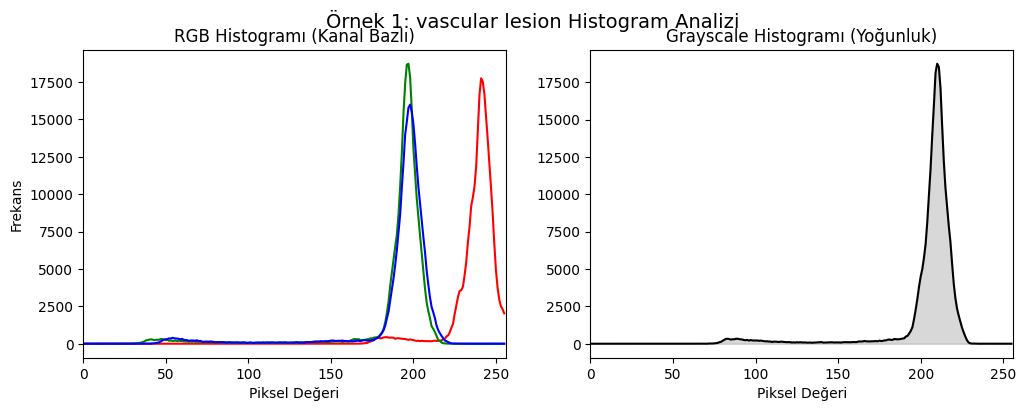

----------------------------------------------------------------------------------------------------


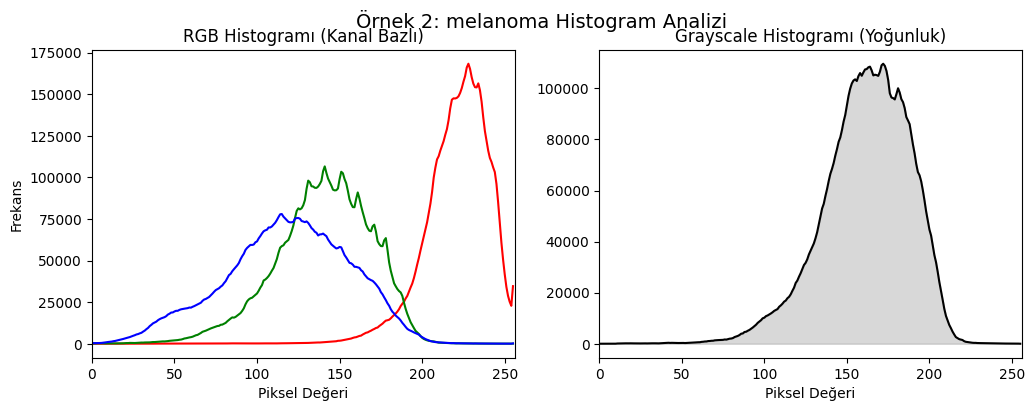

----------------------------------------------------------------------------------------------------


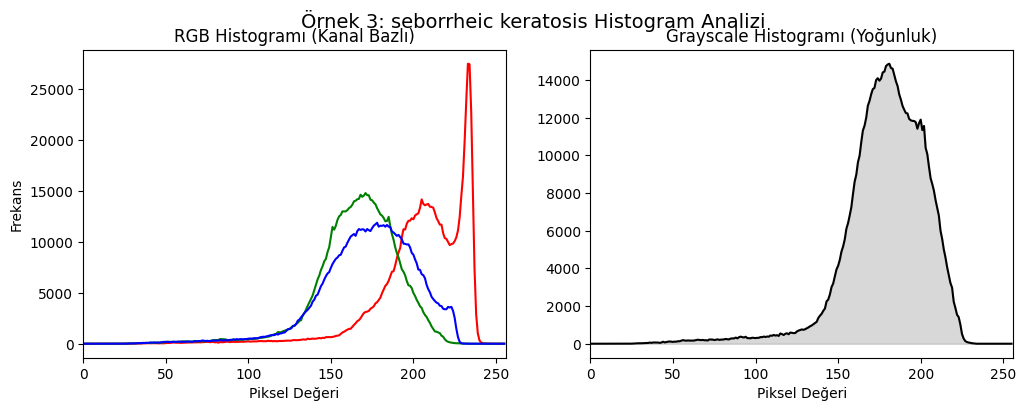

----------------------------------------------------------------------------------------------------


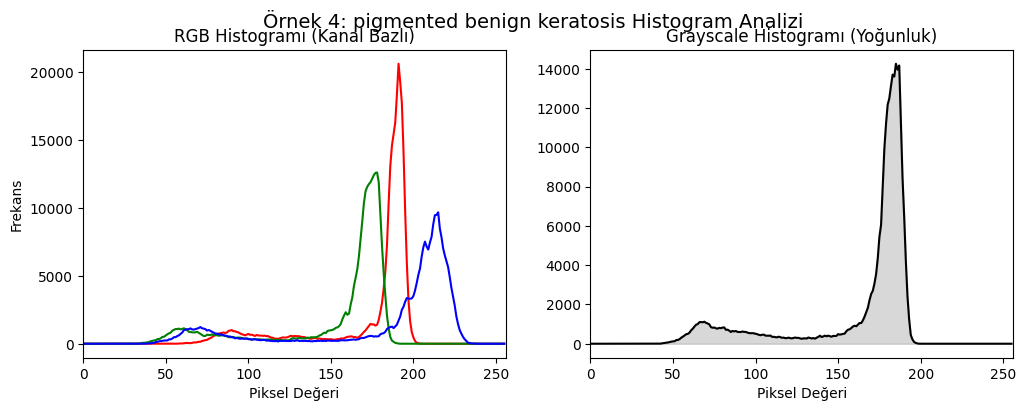

----------------------------------------------------------------------------------------------------


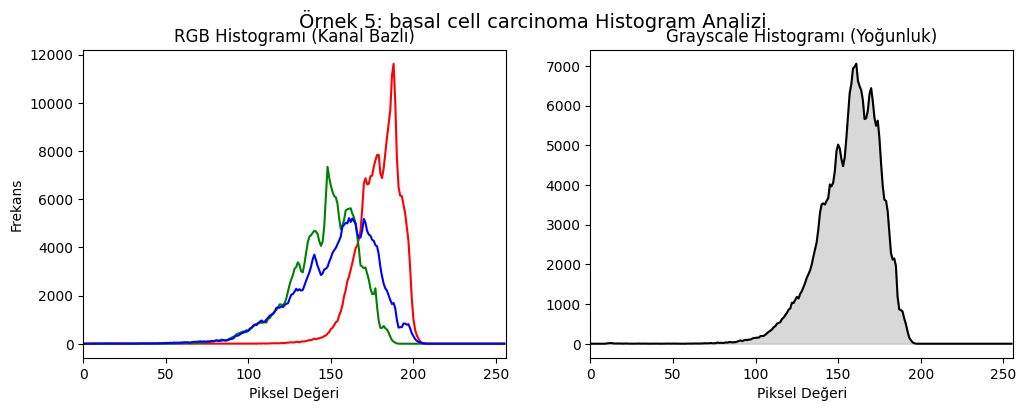

----------------------------------------------------------------------------------------------------


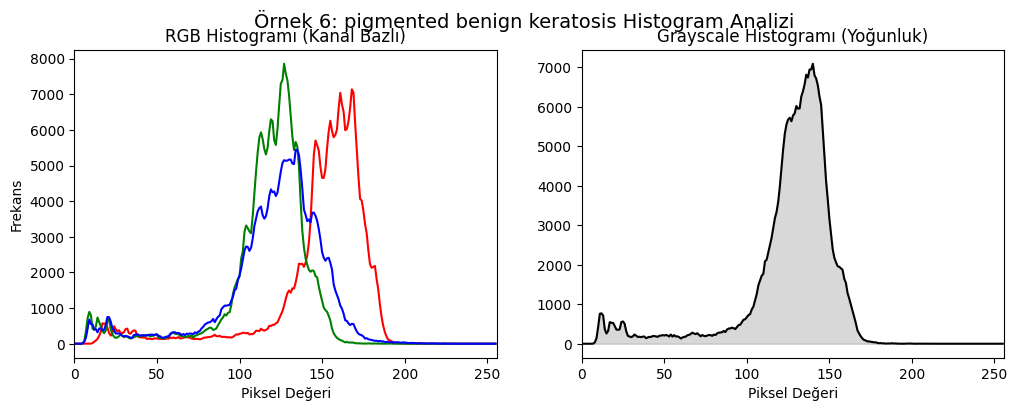

----------------------------------------------------------------------------------------------------


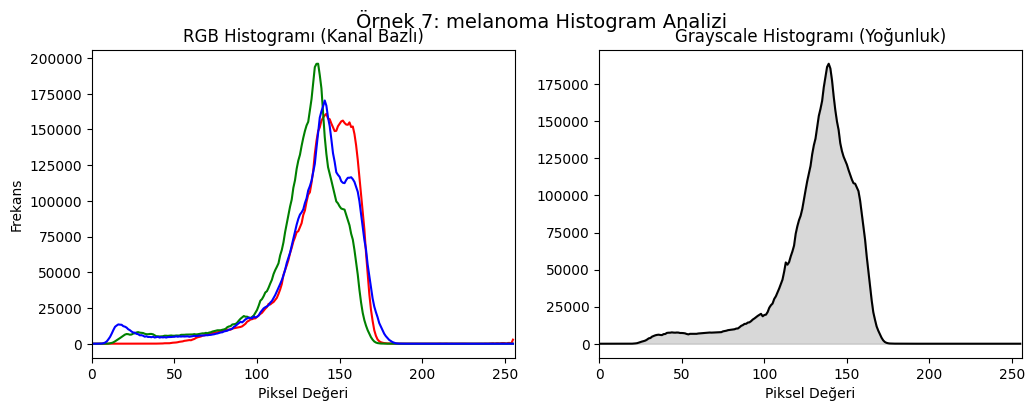

----------------------------------------------------------------------------------------------------


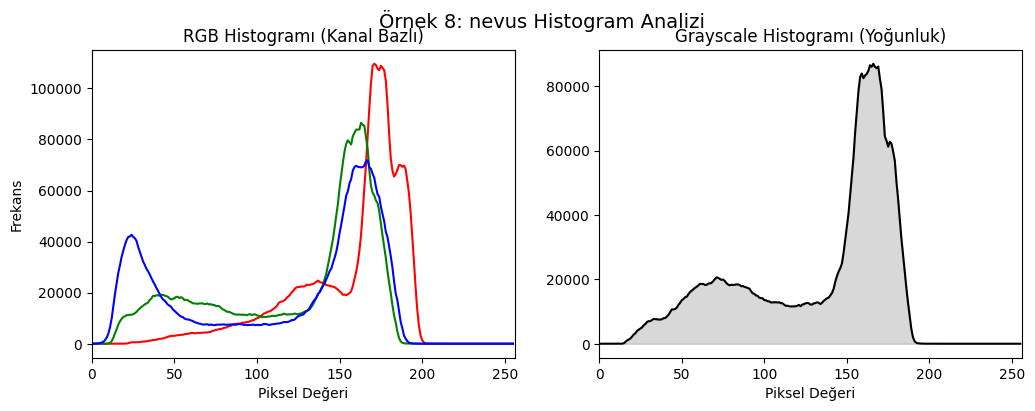

----------------------------------------------------------------------------------------------------


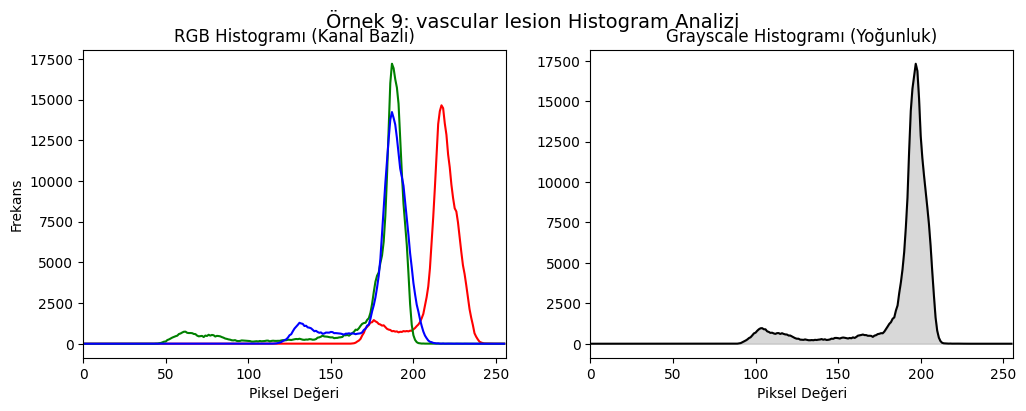

----------------------------------------------------------------------------------------------------


In [7]:
# Her bir seçili görüntü için histogramları çiziyoruz
for i, item in enumerate(selected_images_stats):
    img_rgb = item['rgb']
    img_gray = item['gray']
    label = item['label']

    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Örnek {i+1}: {label} Histogram Analizi", fontsize=14)

    # RGB Histogramı
    plt.subplot(1, 2, 1)
    plt.title("RGB Histogramı (Kanal Bazlı)")
    colors = ('r', 'g', 'b')
    for j, color in enumerate(colors):
        # cv2.calcHist parametreleri: [images], [channels], mask, [histSize], [ranges]
        hist = cv2.calcHist([img_rgb], [j], None, [256], [0, 256])
        plt.plot(hist, color=color)
        plt.xlim([0, 256])
    plt.xlabel("Piksel Değeri")
    plt.ylabel("Frekans")

    # Grayscale Histogramı
    plt.subplot(1, 2, 2)
    plt.title("Grayscale Histogramı (Yoğunluk)")
    hist_gray = cv2.calcHist([img_gray], [0], None, [256], [0, 256])
    plt.plot(hist_gray, color='black')
    plt.fill_between(range(256), hist_gray.flatten(), color='gray', alpha=0.3)
    plt.xlim([0, 256])
    plt.xlabel("Piksel Değeri")

    plt.show()
    print("-" * 100) # Görsel ayrım için çizgi